In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

house = pd.read_csv('kc_house_data.csv')
house.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [2]:
house.insert(1,'recent_built',0)
house['recent_built'] = house.apply(lambda x : x['yr_built']
                            if (x['yr_built']>=x['yr_renovated'])
                            else x['yr_renovated'],axis=1)
house.drop(columns= ['yr_built','yr_renovated'],inplace =True)


house.drop(house[(house['price']>3000000) & (house['bathrooms']==1.75)|(house['price']>1000000)&(house['bathrooms']==0)].index,inplace=True)
house.drop(house[house['price']>3500000].index,inplace=True)
house.drop(house[house['sqft_living']>8000].index,inplace=True)
house.drop(house[house['sqft_above']>7000].index,inplace=True)



In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

y, X = dmatrices('price ~bathrooms+sqft_above+sqft_living15+view+grade+condition',house, return_type = 'dataframe')
vif = pd.DataFrame()
vif["vif value"] = [variance_inflation_factor(X.values,i) for i in range(0,7)]
vif["explanatory variables"] = X.columns
vif

,vif value,explanatory variables
0,101.701657,Intercept
1,2.060369,bathrooms
2,3.217097,sqft_above
3,2.549807,sqft_living15
4,1.110155,view
5,2.908025,grade
6,1.036314,condition


In [4]:
house['view'].value_counts()

0    19480
2      958
3      508
1      331
4      304
Name: view, dtype: int64

In [5]:
house['bathrooms'].value_counts()

2.50    5380
1.00    3852
1.75    3047
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     752
3.50     730
3.25     586
3.75     154
4.00     134
4.50      98
4.25      77
0.75      72
4.75      21
5.00      20
5.25      12
1.25       9
0.00       8
5.50       7
0.50       4
5.75       3
6.00       3
6.50       2
7.50       1
6.75       1
Name: bathrooms, dtype: int64

In [6]:
house['condition'].value_counts()

3    14006
4     5673
5     1700
2      172
1       30
Name: condition, dtype: int64

In [7]:
house['grade'].value_counts()

7     8980
8     6068
9     2615
6     2038
10    1132
11     392
5      242
12      75
4       29
13       6
3        3
1        1
Name: grade, dtype: int64

In [8]:
catvar = ['bathrooms','view','condition','grade']
for c in catvar:
    dummy = pd.get_dummies(house[c],prefix = c, drop_first = True)
    house = pd.concat((house,dummy),axis=1)

In [9]:
from scipy.stats import f_oneway
f_value = {}
for i in catvar:
    groups = [x[1].values for x in house.groupby([i])['price']]
    f_value[i] = f_oneway(*groups)
f_value

{'bathrooms': F_onewayResult(statistic=394.24804325948566, pvalue=0.0),
 'view': F_onewayResult(statistic=1019.6802299071574, pvalue=0.0),
 'condition': F_onewayResult(statistic=44.447209482720616, pvalue=3.1772034277119416e-37),
 'grade': F_onewayResult(statistic=2005.0924547964355, pvalue=0.0)}

In [10]:
import statsmodels.api as sm

X1 = house.drop(catvar+['price','id','sqft_lot15','waterfront','lat','long','zipcode','recent_built','sqft_basement','date','bedrooms','sqft_living','sqft_lot','floors','sqft_basement'],axis=1)
y = house['price']

X1 = sm.add_constant(X1)
model = sm.OLS(y,X1)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     732.8
Date:                Wed, 29 Sep 2021   Prob (F-statistic):               0.00
Time:                        13:06:01   Log-Likelihood:            -2.9511e+05
No. Observations:               21581   AIC:                         5.903e+05
Df Residuals:                   21533   BIC:                         5.907e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3.089e+04    2.1e+05      0.147      0.883   -3.82e+05    4.43e+05
sqft_above        36.9703      3.292     11.231      0.000      30.518      43.422
sqft_living15     61.9659      3.434     18.043      0.000      55.234      68.698
bathrooms_0.5   3.376e+04   1.38e+05      0.245      0.806   -2.36e+05    3.03e+05
bathrooms_0.75  7.609e+04   9.14e+04      0.832      0.405   -1.03e+05    2.55e+05
bathrooms_1.0   1.056e+05   8.86e+04      1.193      0.233    -6.8e+04    2.79e+05
bathrooms_1.25  1.152e+05   1.13e+05      1.020      0.308   -1.06e+05    3.37e+05
bathrooms_1.5   9.745e+04   8.86e+04      1.099      0.272   -7.63e+04    2.71e+05
bathrooms_1.75  1.019e+05   8.86e+04      1.151      0.250   -7.17e+04    2.75e+05
bathrooms_2.0   1.102e+05   8.86e+04      1.243      0.214   -6.35e+04    2.84e+05
bathrooms_2.25  1.068e+05   8.86e+04      1.206      0.228   -6.68e+04     2.8e+05
bathrooms_2.5   6.197e+04   8.85e+04      0.700      0.484   -1.12e+05    2.36e+05
bathrooms_2.75  1.209e+05   8.87e+04      1.363      0.173    -5.3e+04    2.95e+05
bathrooms_3.0   1.739e+05   8.88e+04      1.958      0.050    -201.608    3.48e+05
bathrooms_3.25  2.374e+05    8.9e+04      2.668      0.008     6.3e+04    4.12e+05
bathrooms_3.5   1.911e+05   8.89e+04      2.149      0.032    1.68e+04    3.65e+05
bathrooms_3.75  3.426e+05   9.02e+04      3.797      0.000    1.66e+05    5.19e+05
bathrooms_4.0   3.553e+05   9.05e+04      3.926      0.000    1.78e+05    5.33e+05
bathrooms_4.25  4.422e+05   9.19e+04      4.811      0.000    2.62e+05    6.22e+05
bathrooms_4.5   3.354e+05   9.12e+04      3.677      0.000    1.57e+05    5.14e+05
bathrooms_4.75  8.254e+05      1e+05      8.253      0.000    6.29e+05    1.02e+06
bathrooms_5.0   4.322e+05   1.01e+05      4.298      0.000    2.35e+05    6.29e+05
bathrooms_5.25  5.355e+05   1.08e+05      4.974      0.000    3.24e+05    7.46e+05
bathrooms_5.5   4.981e+05    1.2e+05      4.145      0.000    2.63e+05    7.34e+05
bathrooms_5.75  1.239e+05   1.52e+05      0.817      0.414   -1.73e+05    4.21e+05
bathrooms_6.0   1.502e+05   1.51e+05      0.992      0.321   -1.47e+05    4.47e+05
bathrooms_6.5   4.669e+05   1.74e+05      2.684      0.007    1.26e+05    8.08e+05
bathrooms_6.75 -4.233e+05   2.29e+05     -1.850      0.064   -8.72e+05    2.51e+04
bathrooms_7.5   1.049e+05   2.28e+05      0.459      0.646   -3.43e+05    5.53e+05
view_1          1.697e+05   1.18e+04     14.417      0.000    1.47e+05    1.93e+05
view_2          1.042e+05   7115.038     14.650      0.000    9.03e+04    1.18e+05
view_3           1.84e+05   9714.090     18.939      0.000    1.65e+05    2.03e+05
view_4          4.924e+05   1.25e+04     39.479      0.000    4.68e+05    5.17e+05
condition_2    -7020.8696   4.24e+04     -0.166      0.868   -9.01e+04    7.61e+04
condition_3 

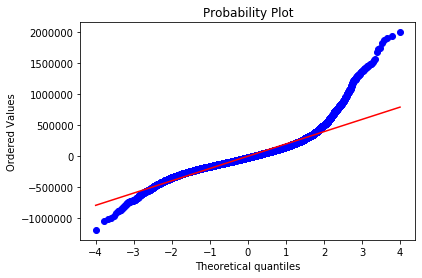

In [22]:
# Error's Q-Q plot

import scipy.stats

residual = house['price'] - result.predict()
scipy.stats.probplot(residual, dist=scipy.stats.norm, plot=plt)
plt.show()

In [12]:
house['long'].describe()

count    21581.000000
mean      -122.213916
std          0.140854
min       -122.519000
25%       -122.328000
50%       -122.231000
75%       -122.125000
max       -121.315000
Name: long, dtype: float64

In [13]:
house['lat'].describe()

count    21581.000000
mean        47.559963
std          0.138623
min         47.155900
25%         47.470600
50%         47.571700
75%         47.678000
max         47.777600
Name: lat, dtype: float64

In [14]:
house['zipcode'].value_counts()

98103    602
98038    590
98115    583
98052    574
98117    553
        ... 
98102    103
98010    100
98024     81
98148     57
98039     44
Name: zipcode, Length: 70, dtype: int64

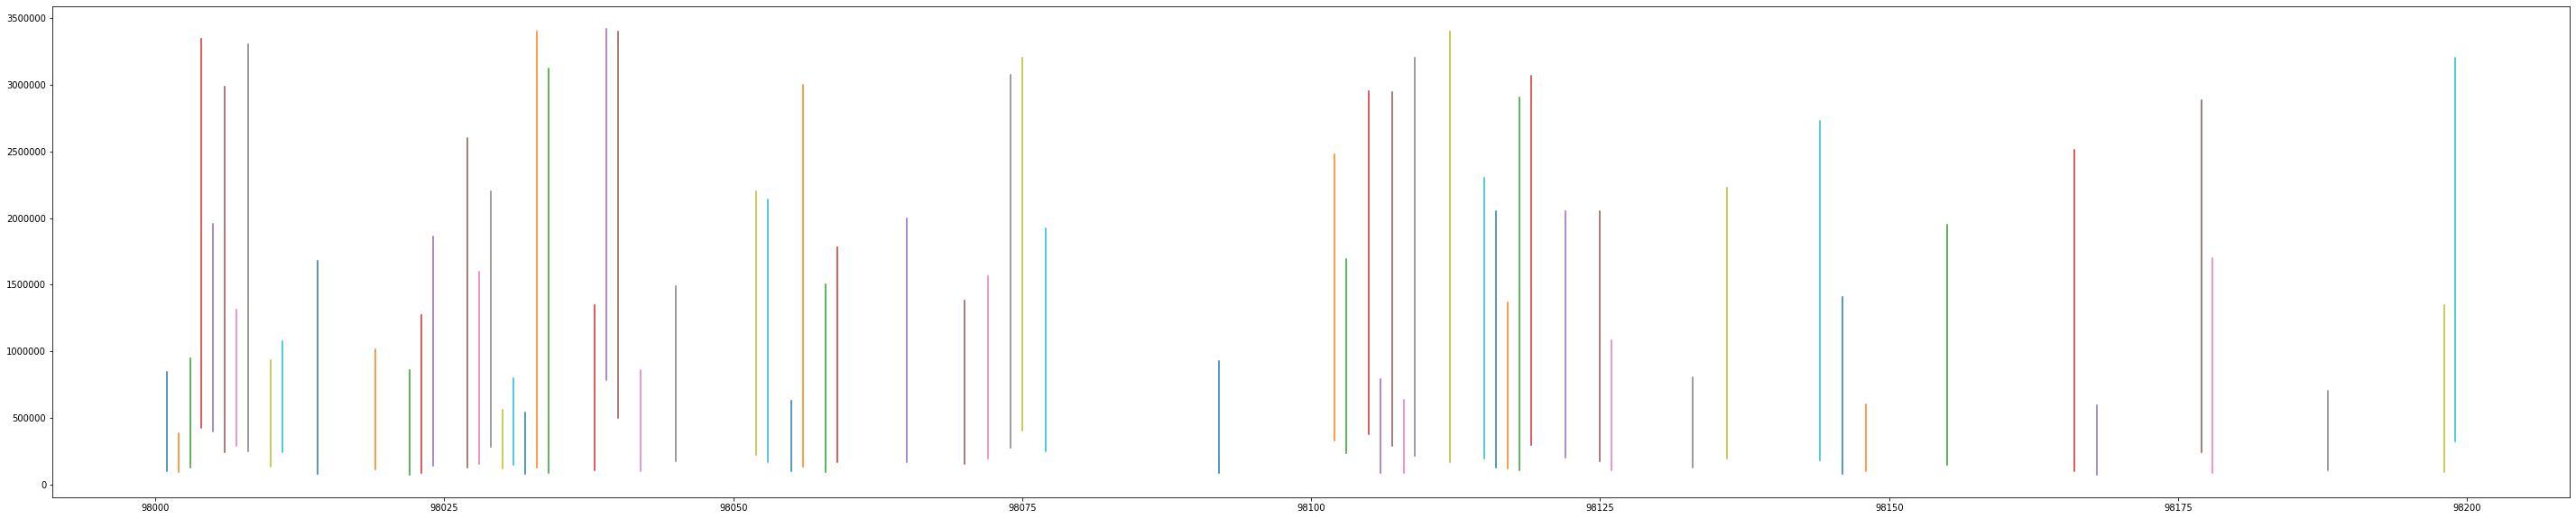

In [15]:
price_min = house.groupby('zipcode')['price'].min()
price_max = house.groupby('zipcode')['price'].max()

plt.figure(figsize=(50,10))
for x in price_min.index:
    plt.plot([x,x],[price_min[x],price_max[x]])
    
#by this graph i can see the min_price value don't high difference between zipcode

<ErrorbarContainer object of 3 artists>

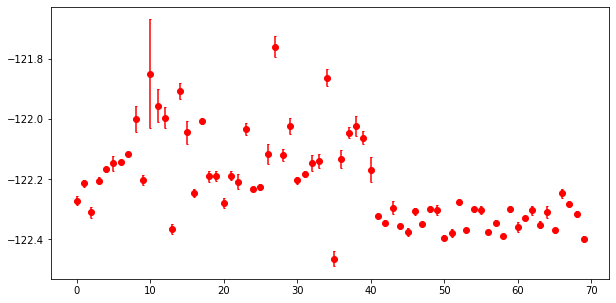

In [16]:
long_mean = house.groupby('zipcode')['long'].mean()
long_std = house.groupby('zipcode')['long'].std()

plt.figure(figsize=(10,5))

plt.errorbar(range(len(long_mean)),long_mean,yerr=long_std, fmt='o', c='r',ecolor='r',capthick=1,capsize=1)

<ErrorbarContainer object of 3 artists>

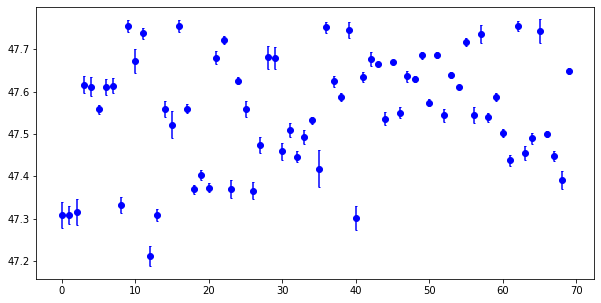

In [17]:
plt.figure(figsize=(10,5))

lat_mean = house.groupby('zipcode')['lat'].mean()
lat_std = house.groupby('zipcode')['lat'].std()

plt.errorbar(range(len(lat_mean)),lat_mean,yerr=lat_std, fmt='o', c='b',ecolor='b',capthick=1,capsize=1)

In [18]:
print("Depending on zipcode value mean of standard deviation of 'lat'\n\n",lat_std.mean(),"\n") 

print("standard deviation of 'lat' column \n\n" ,house['lat'].std())

print("Depending on zipcode value mean of standard deviation of 'long'\n\n",long_std.mean(),"\n") 

print("standard deviation of 'long' column \n\n" ,house['long'].std())

Depending on zipcode value mean of standard deviation of 'lat'

 0.01589899563147026 

standard deviation of 'lat' column 

 0.1386231069375018
Depending on zipcode value mean of standard deviation of 'long'

 0.019429508395824427 

standard deviation of 'long' column 

 0.14085387080836465


<ErrorbarContainer object of 3 artists>

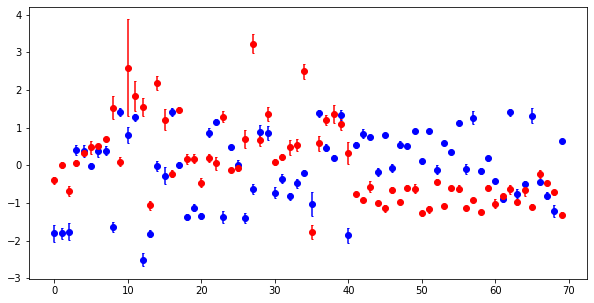

In [19]:
# for show two graph in one graph standardization 
# So i can see those graph in one graph
house['lat'] = (house['lat'] - house['lat'].mean())/house['lat'].std()
house['long'] = (house['long'] - house['long'].mean())/house['long'].std()

long_mean = house.groupby('zipcode')['long'].mean()
long_std = house.groupby('zipcode')['long'].std()
lat_mean = house.groupby('zipcode')['lat'].mean()
lat_std = house.groupby('zipcode')['lat'].std()

plt.figure(figsize=(10,5))
plt.errorbar(range(len(lat_mean)),lat_mean,yerr=lat_std, fmt='o', c='b',ecolor='b',capthick=1,capsize=1)
plt.errorbar(range(len(long_mean)),long_mean,yerr=long_std, fmt='o', c='r',ecolor='r',capthick=1,capsize=1)

<ErrorbarContainer object of 3 artists>

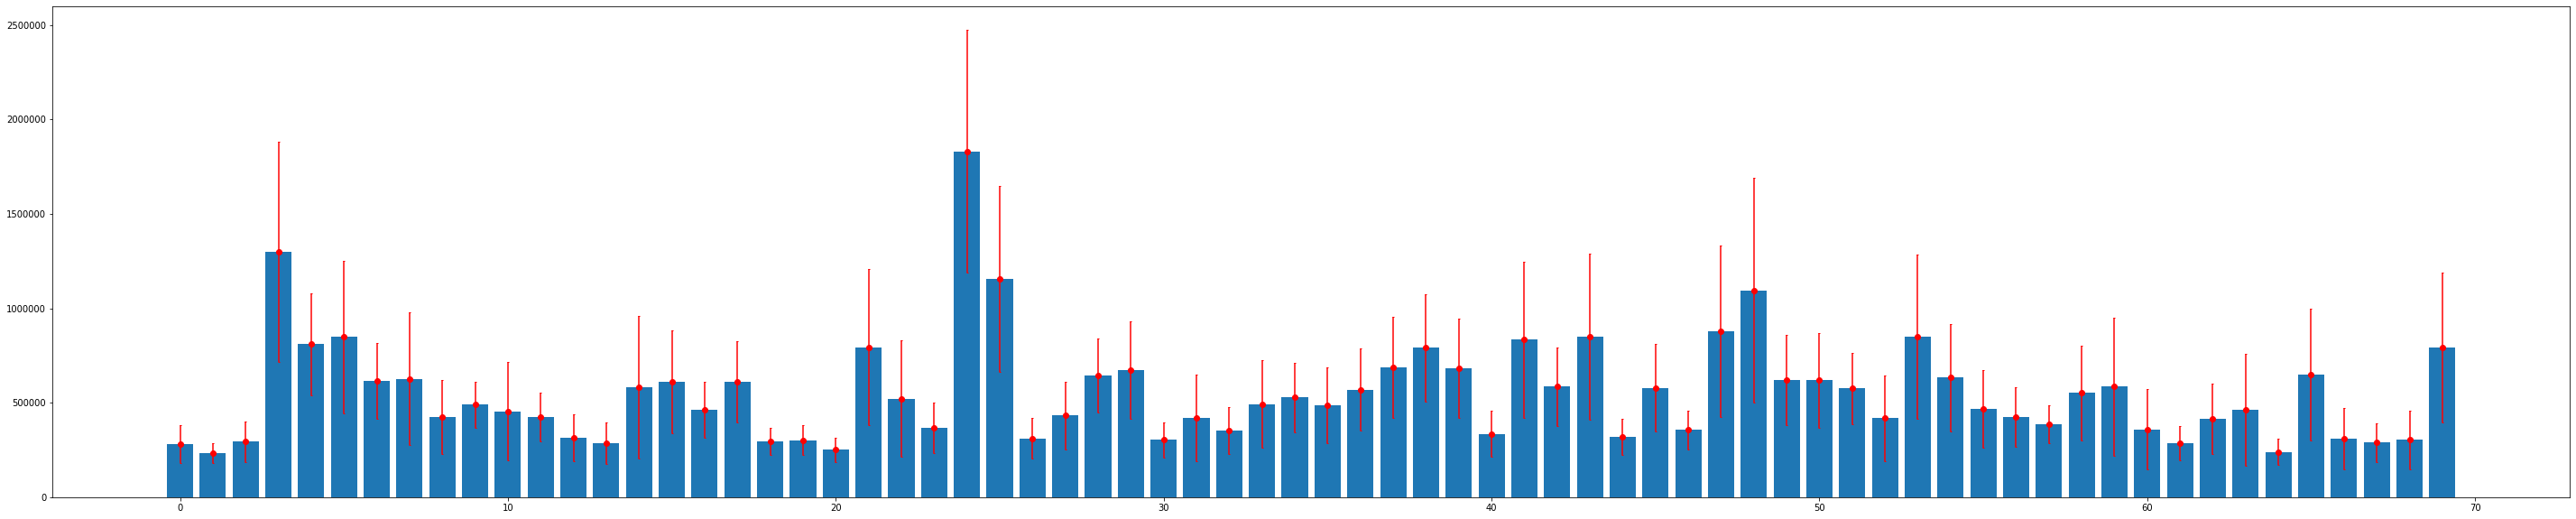

In [20]:
price_mean = house.groupby('zipcode')['price'].mean()
price_std = house.groupby('zipcode')['price'].std()

plt.figure(figsize=(50,10))
plt.bar(range(len(price_mean)),price_mean)
plt.errorbar(range(len(price_mean)),price_mean,yerr=price_std, fmt='o', c='r',ecolor='r',capthick=1,capsize=1)

In [21]:
price_mean.describe()

count    7.000000e+01
mean     5.520771e+05
std      2.734145e+05
min      2.342840e+05
25%      3.528348e+05
50%      4.919520e+05
75%      6.425136e+05
max      1.831578e+06
Name: price, dtype: float64